In [1]:
import pandas as pd

df=pd.read_excel("60 günlük veriler.xlsx")
df.head()
df["Datetime"] = pd.to_datetime(df["Analiz Tarihi"], dayfirst=True)

df = df.sort_values("Datetime").reset_index(drop=True)

df_raw = df.copy()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
PARAMETERS = {
    "NaHCO3 (%)": {"LSL": 99.6, "USL": 99.9},
    "Na2CO3 (%)": {"LSL": 0.08, "USL": 0.15},
    "Cl- (mg/kg)": {"USL": 200},
    "SO42-(mg/kg)": {"USL": 300},
    "SÇM (mg/kg)": {"USL": 600},
    "Nem (%)": {"USL": 0.05},
    "Yığın Yoğunluğu (g/cm3)": {"LSL": 1.05, "USL": 1.25}
}


In [3]:
import numpy as np
df_imputed = df.copy()

PARAM_COLS = list(PARAMETERS.keys())

for col in PARAM_COLS:
    # ---- SPC LIMITLERİNİ HESAPLA (HAM VERİDEN) ----
    x = df[col].values
    MR = np.abs(np.diff(x))
    d2 = 1.128

    x_bar = np.nanmean(x)
    MR_bar = np.nanmean(MR)
    sigma = MR_bar / d2 if MR_bar > 0 else 0

    UCL = x_bar + 3 * sigma
    LCL = x_bar - 3 * sigma

    # ---- OUTLIER = NaN ----
    outlier_mask = (df_imputed[col] < LCL) | (df_imputed[col] > UCL)
    df_imputed.loc[outlier_mask, col] = np.nan

    # ---- ±3 GÜN LOKAL MEAN IMPUTATION ----
    for i in range(len(df_imputed)):
        if pd.isna(df_imputed.loc[i, col]):
            start = max(0, i - 3)
            end = min(len(df_imputed), i + 4)

            window_mean = df_imputed.loc[start:end, col].mean()
            df_imputed.loc[i, col] = window_mean
df_imputed = df_imputed.sort_values("Datetime").reset_index(drop=True)
df = df.sort_values("Datetime").reset_index(drop=True)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def draw_imr(df, value_col, title_suffix):
    # NaN'leri ayıkla
    x = df[value_col].dropna().values
    dates = df.loc[df[value_col].notna(), "Datetime"].values

    # Moving Range
    MR = np.abs(np.diff(x))

    d2 = 1.128
    x_bar = np.mean(x)
    MR_bar = np.mean(MR)
    sigma = MR_bar / d2 if MR_bar > 0 else 0

    # Limitler
    UCL_I = x_bar + 3 * sigma
    LCL_I = x_bar - 3 * sigma
    UCL_MR = 3.267 * MR_bar

    # =====================
    # I-CHART
    # =====================
    plt.figure(figsize=(14,4))
    plt.plot(dates, x, marker="o")
    plt.axhline(x_bar, linestyle="--", label="CL")
    plt.axhline(UCL_I, color="red", linestyle="--", label="UCL")
    plt.axhline(LCL_I, color="red", linestyle="--", label="LCL")
    plt.title(f"{value_col} – I-Chart ({title_suffix})")
    plt.ylabel(value_col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =====================
    # MR-CHART
    # =====================
    plt.figure(figsize=(14,4))
    plt.plot(dates[1:], MR, marker="o")
    plt.axhline(MR_bar, linestyle="--", label="CL")
    plt.axhline(UCL_MR, color="red", linestyle="--", label="UCL")
    plt.title(f"{value_col} – MR-Chart ({title_suffix})")
    plt.ylabel("Moving Range")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "mean": x_bar,
        "sigma": sigma
    }


In [5]:
def cp_cpk(mean, sigma, LSL=None, USL=None):
    Cp = None
    Cpk = None

    if sigma == 0 or sigma is None:
        return Cp, Cpk

    if LSL is not None and USL is not None:
        Cp = (USL - LSL) / (6 * sigma)
        Cpk = min(
            (USL - mean) / (3 * sigma),
            (mean - LSL) / (3 * sigma)
        )
    elif USL is not None:
        Cp = (USL - mean) / (3 * sigma)
        Cpk = Cp
    elif LSL is not None:
        Cp = (mean - LSL) / (3 * sigma)
        Cpk = Cp

    return Cp, Cpk



PARAMETRE: NaHCO3 (%)


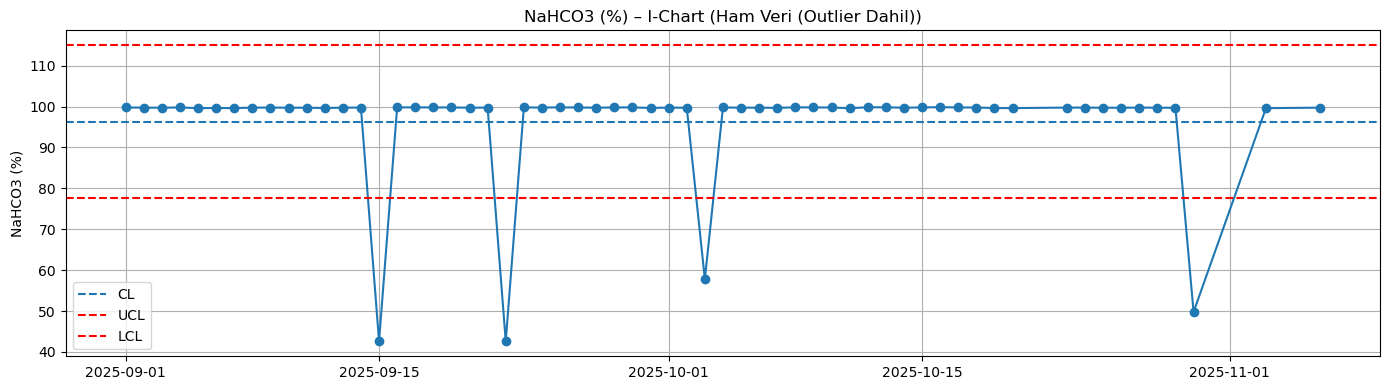

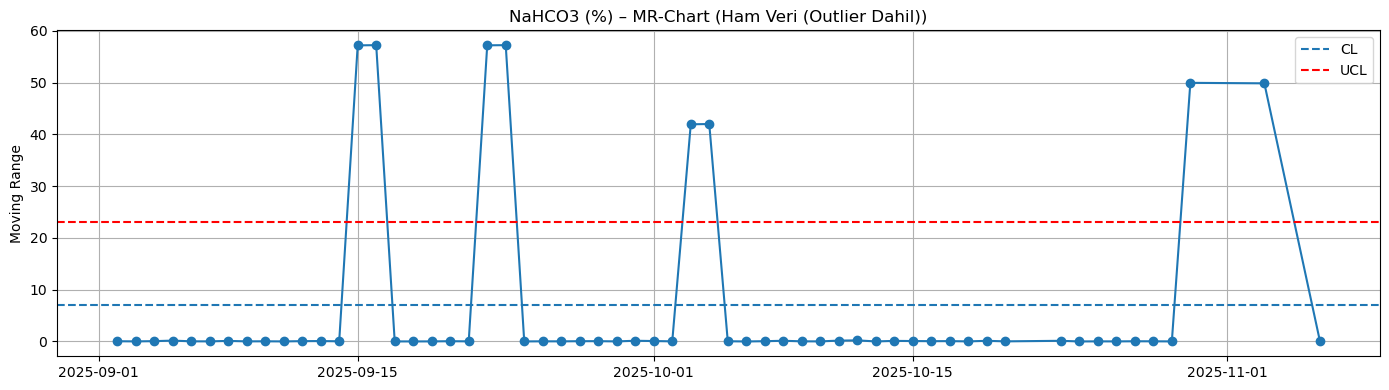

HAM → Mean: 96.3029 Sigma: 6.2383 Cp: 0.008014964349835816 Cpk: -0.17617399255347196


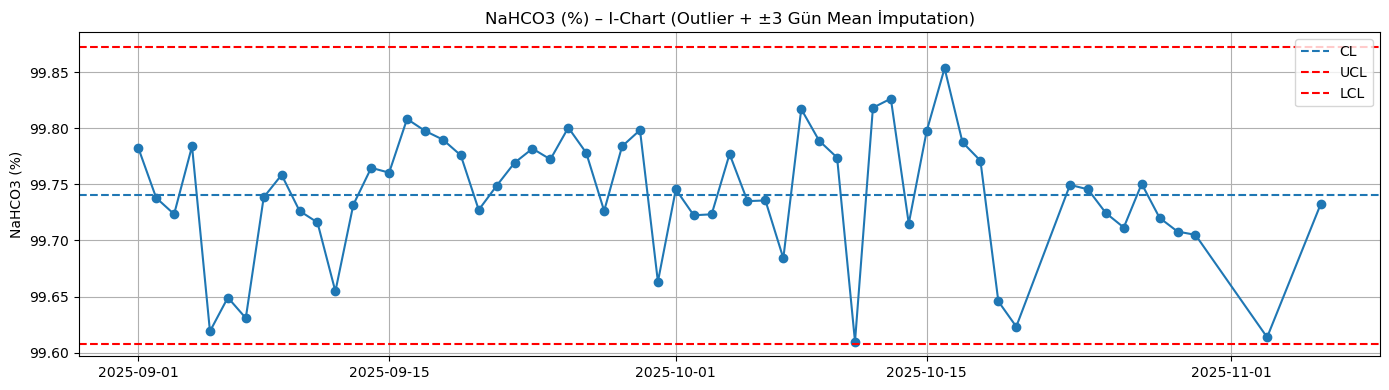

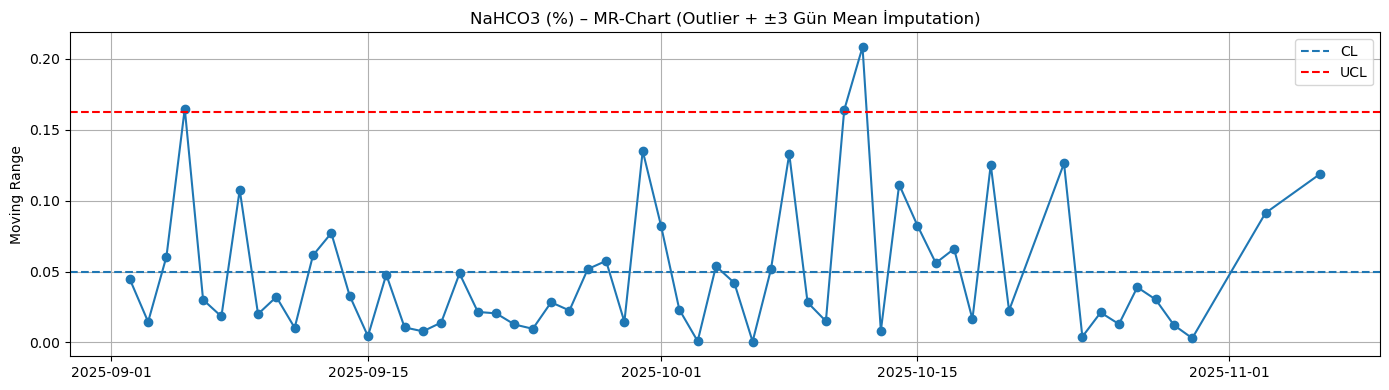

IMPUTE → Mean: 99.7401 Sigma: 0.044 Cp: 1.1354228613210047 Cpk: 1.0607664652529787

PARAMETRE: Na2CO3 (%)


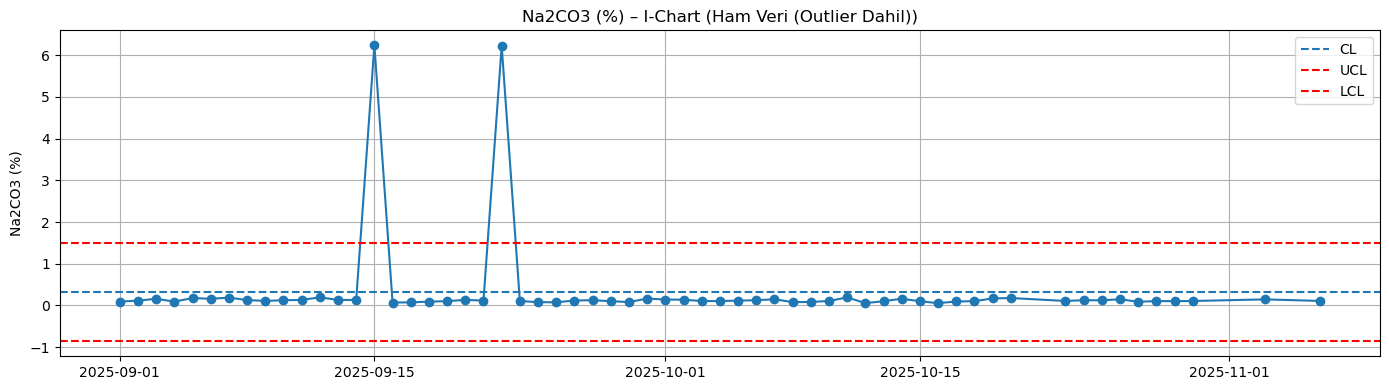

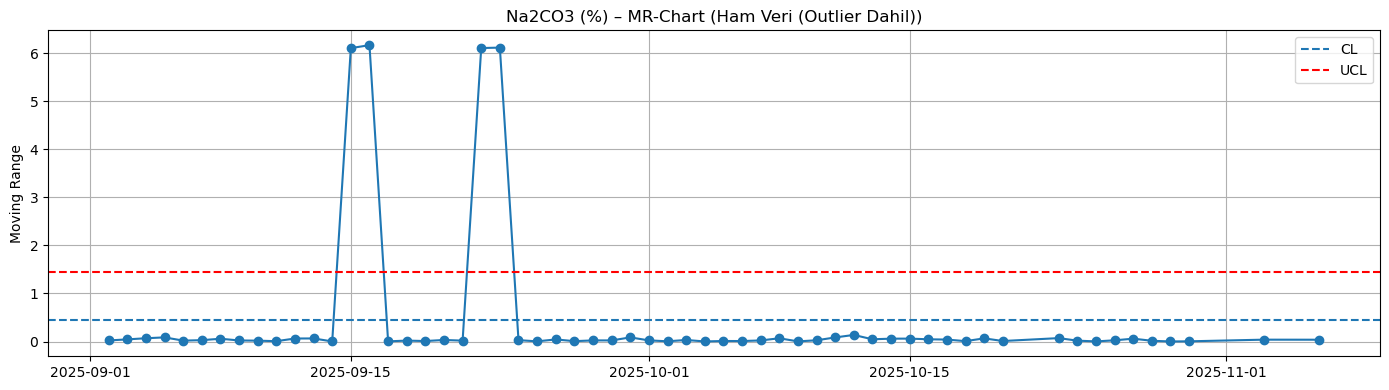

HAM → Mean: 0.322 Sigma: 0.3956 Cp: 0.029491484221881217 Cpk: -0.14492957960467348


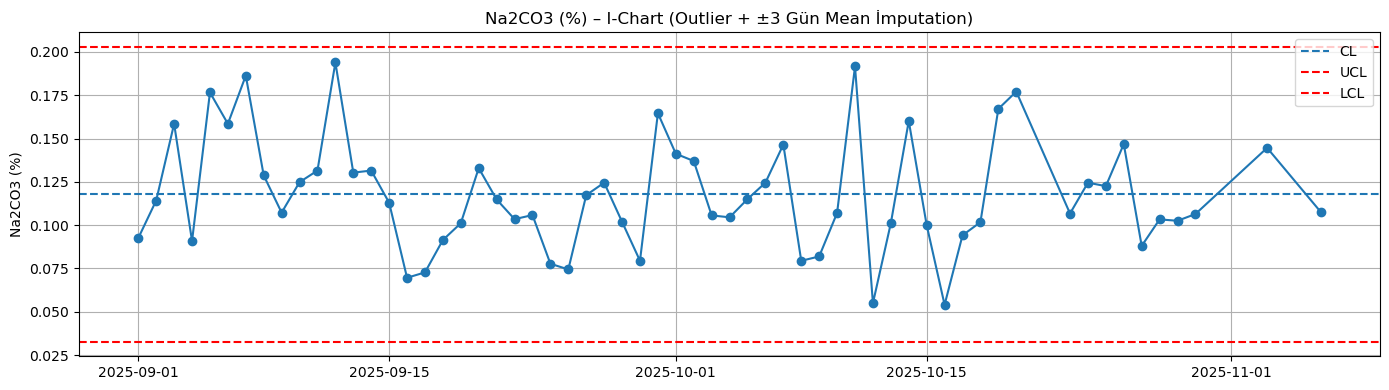

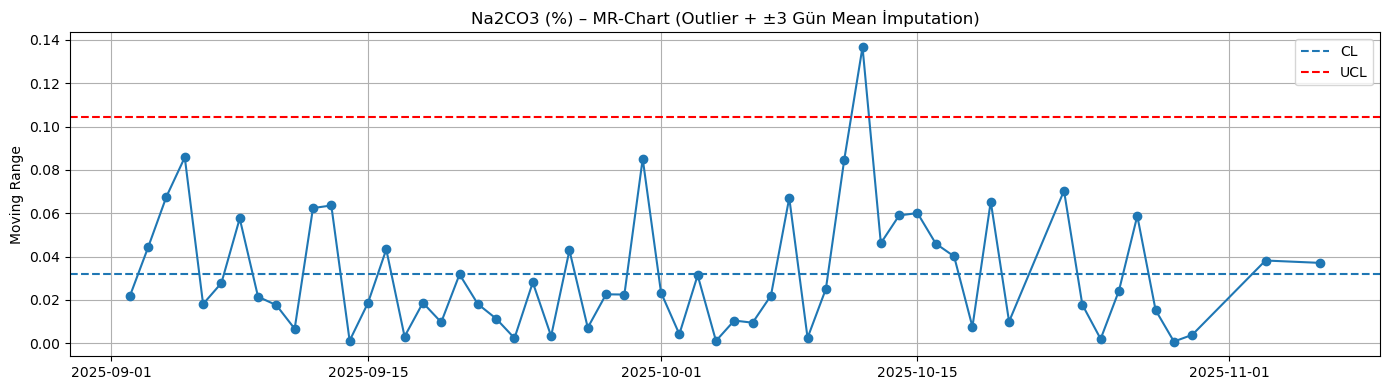

IMPUTE → Mean: 0.1178 Sigma: 0.0283 Cp: 0.4116985819900617 Cpk: 0.37898674908091945

PARAMETRE: Cl- (mg/kg)


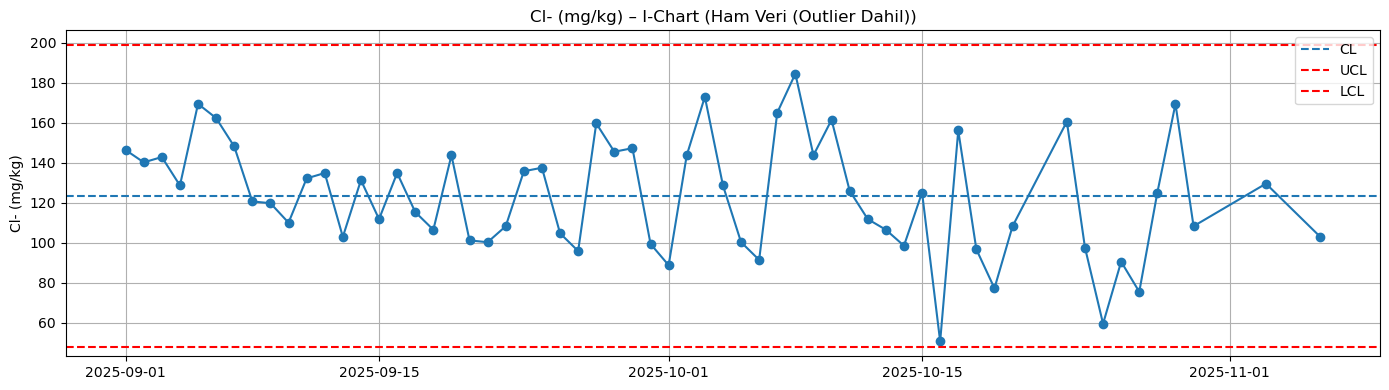

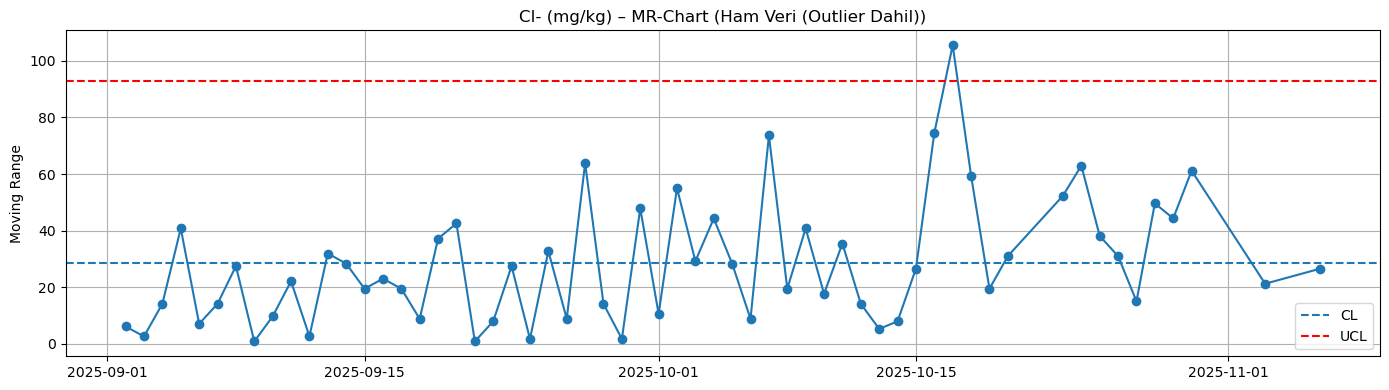

HAM → Mean: 123.1379 Sigma: 25.1936 Cp: 1.0169513474397311 Cpk: 1.0169513474397311


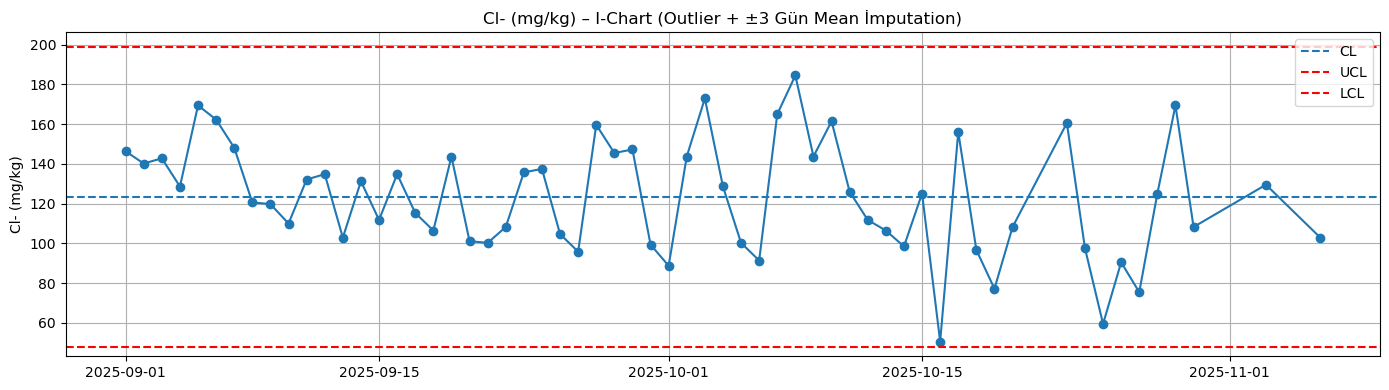

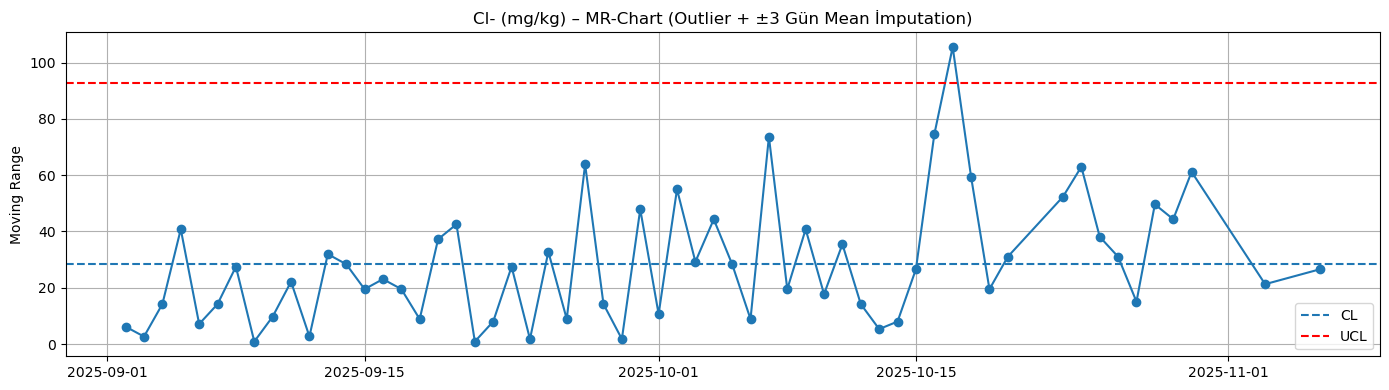

IMPUTE → Mean: 123.1379 Sigma: 25.1936 Cp: 1.0169513474397311 Cpk: 1.0169513474397311

PARAMETRE: SO42-(mg/kg)


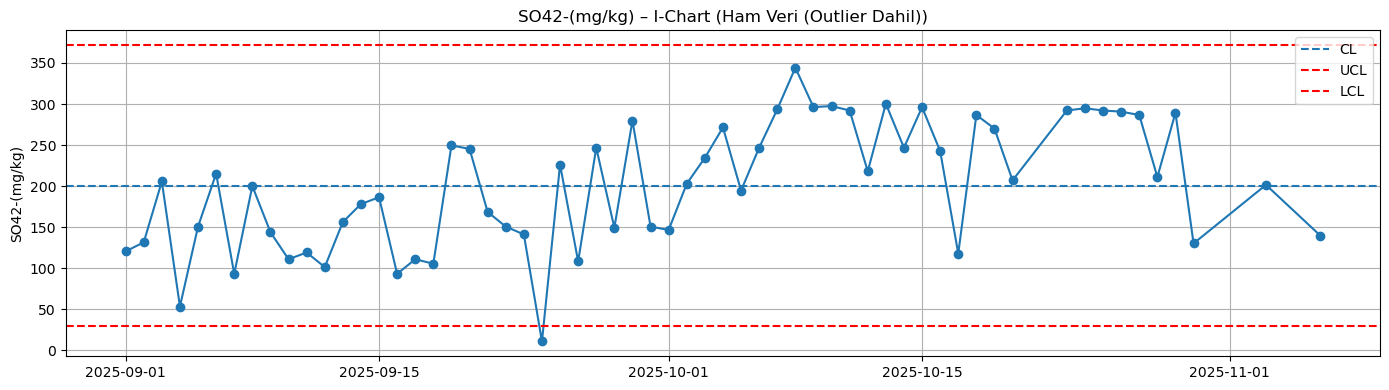

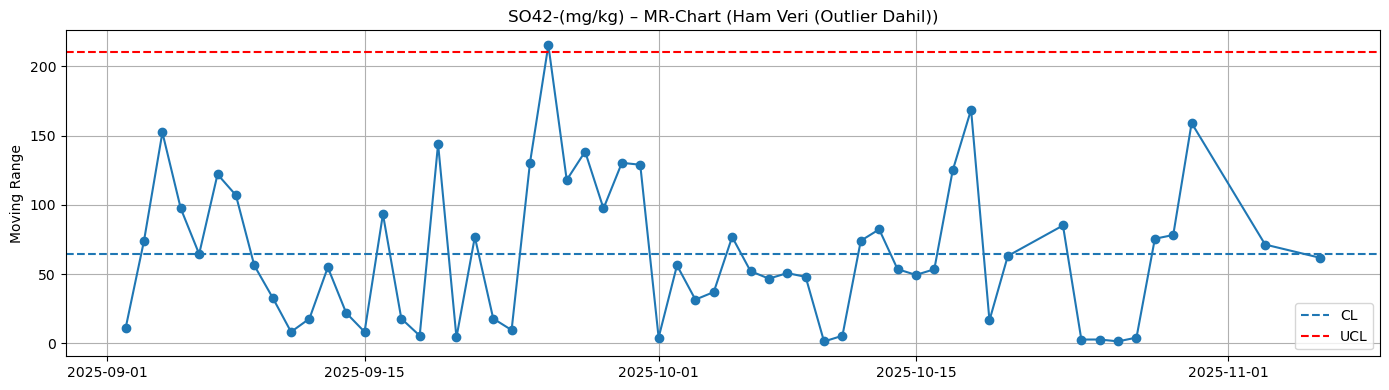

HAM → Mean: 200.7047 Sigma: 57.0019 Cp: 0.5806551605202199 Cpk: 0.5806551605202199


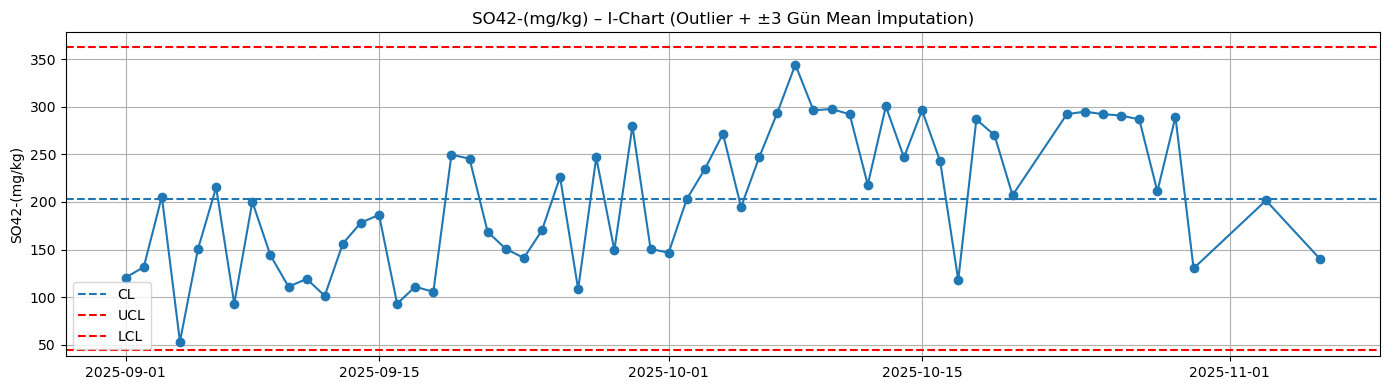

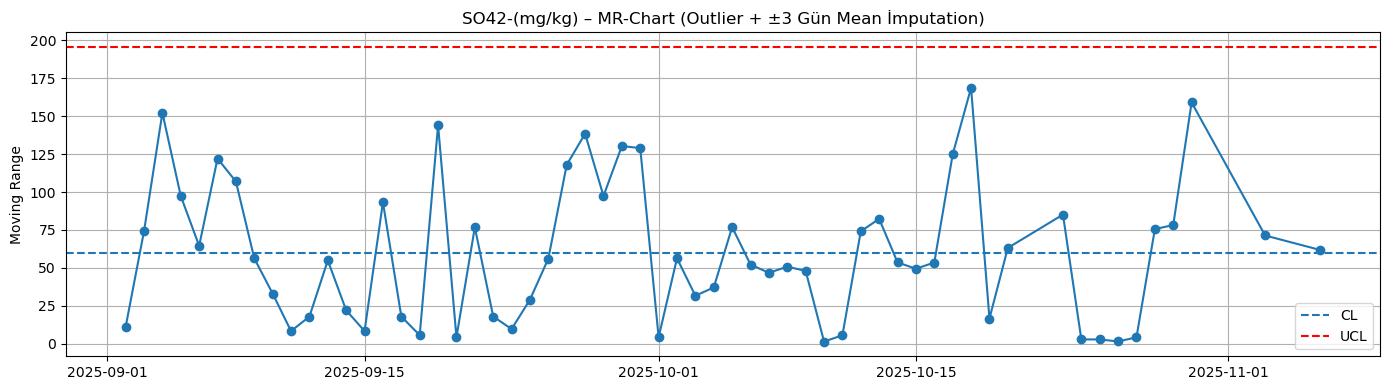

IMPUTE → Mean: 203.3591 Sigma: 53.0863 Cp: 0.606815806728523 Cpk: 0.606815806728523

PARAMETRE: SÇM (mg/kg)


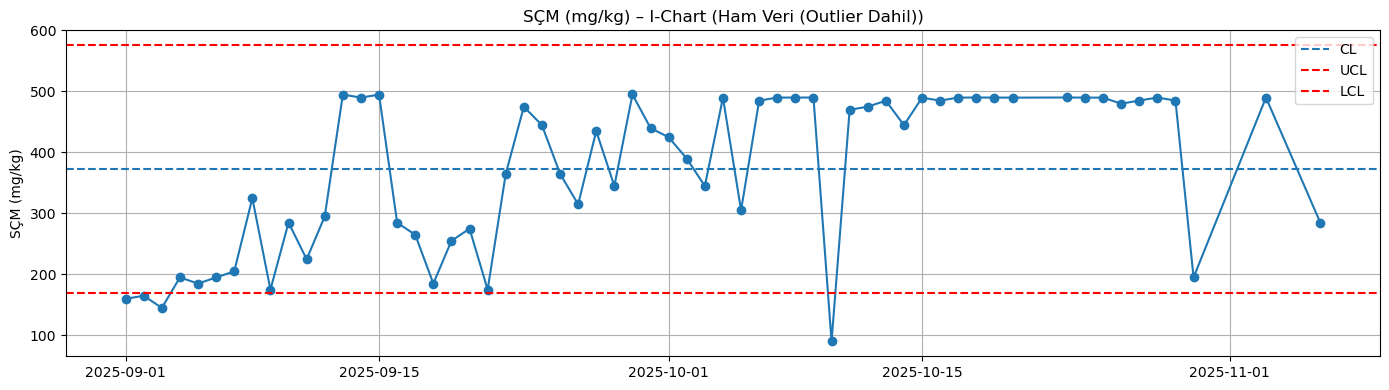

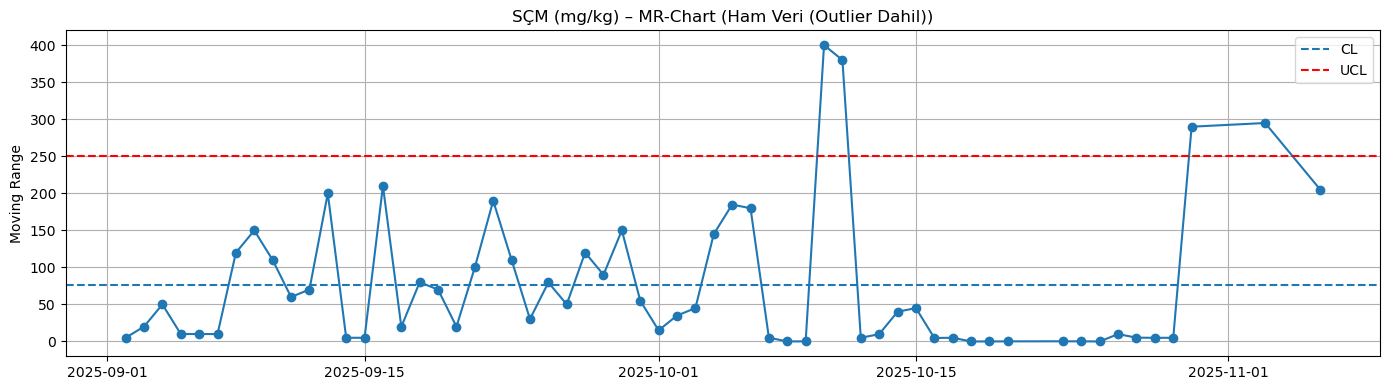

HAM → Mean: 372.3025 Sigma: 67.8419 Cp: 1.1187658484613485 Cpk: 1.1187658484613485


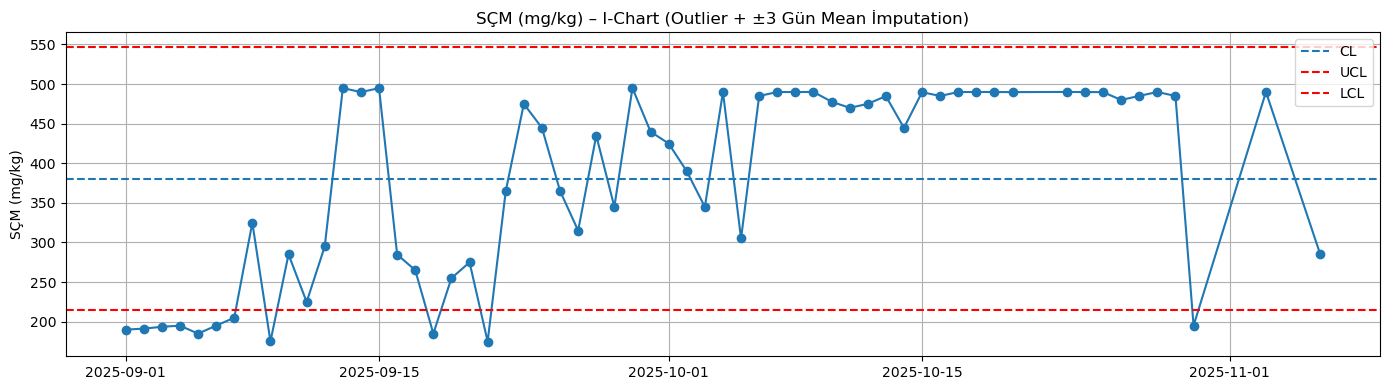

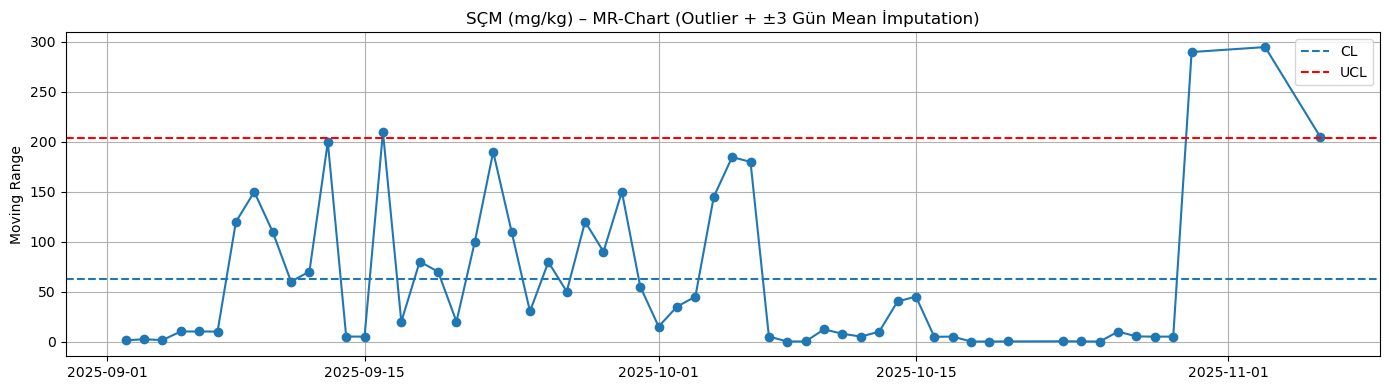

IMPUTE → Mean: 380.5114 Sigma: 55.3712 Cp: 1.321316116106985 Cpk: 1.321316116106985

PARAMETRE: Nem (%)


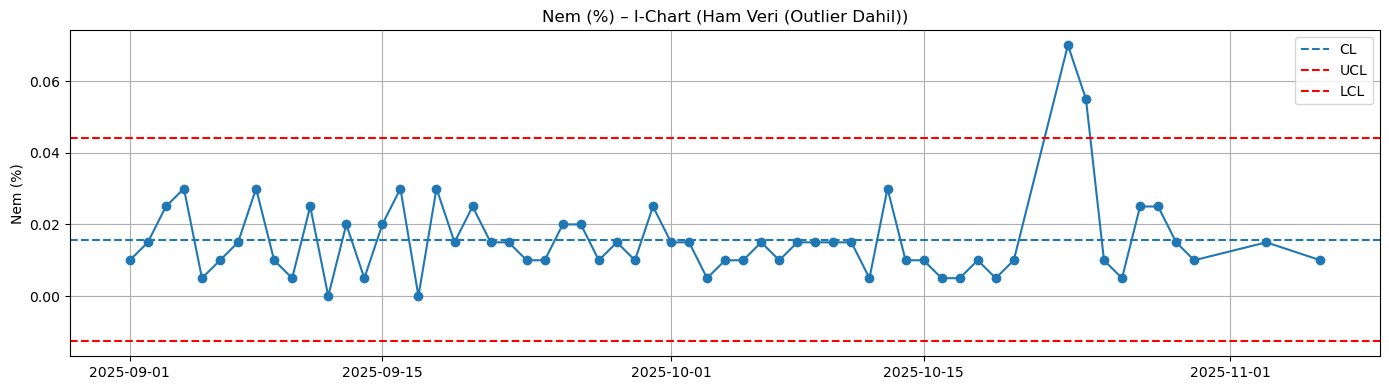

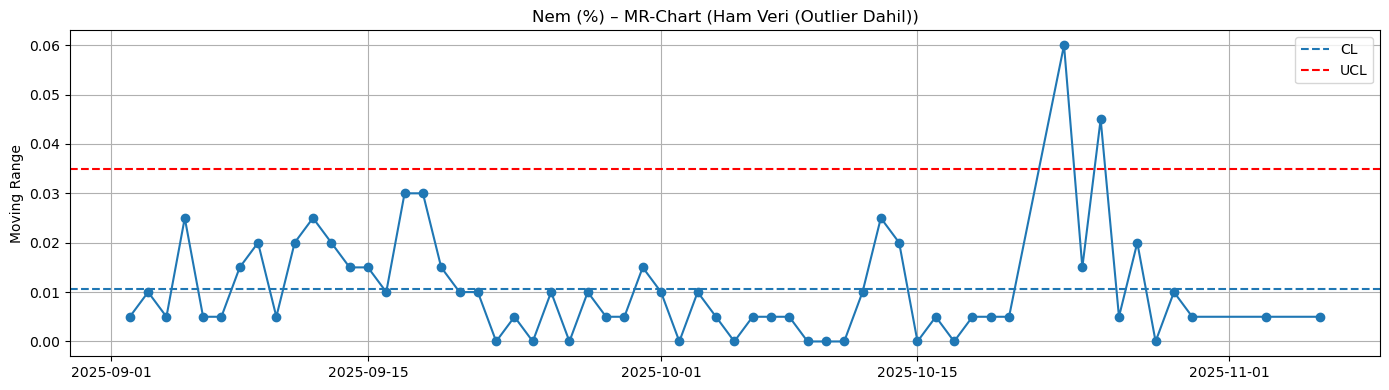

HAM → Mean: 0.0158 Sigma: 0.0095 Cp: 1.2060349206349206 Cpk: 1.2060349206349206


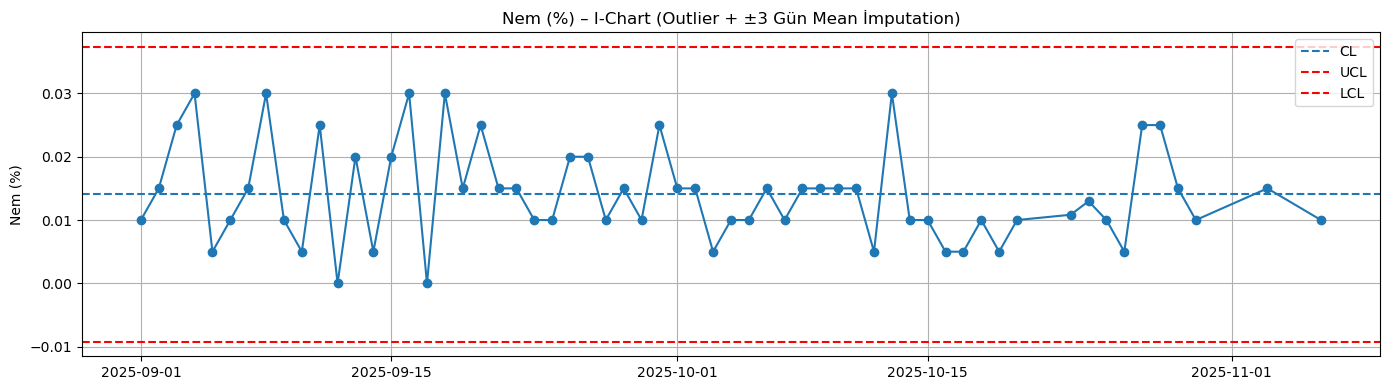

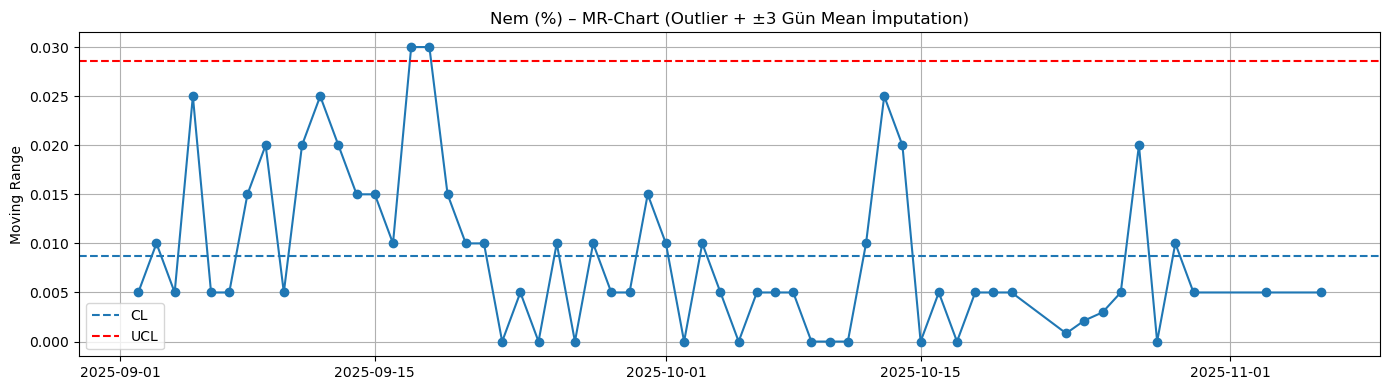

IMPUTE → Mean: 0.0141 Sigma: 0.0078 Cp: 1.5451338563297954 Cpk: 1.5451338563297954

PARAMETRE: Yığın Yoğunluğu (g/cm3)


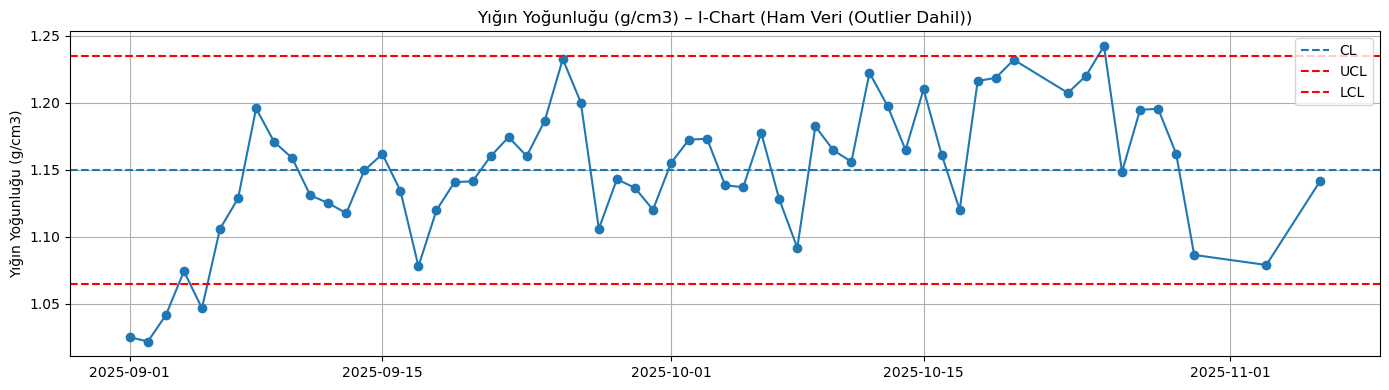

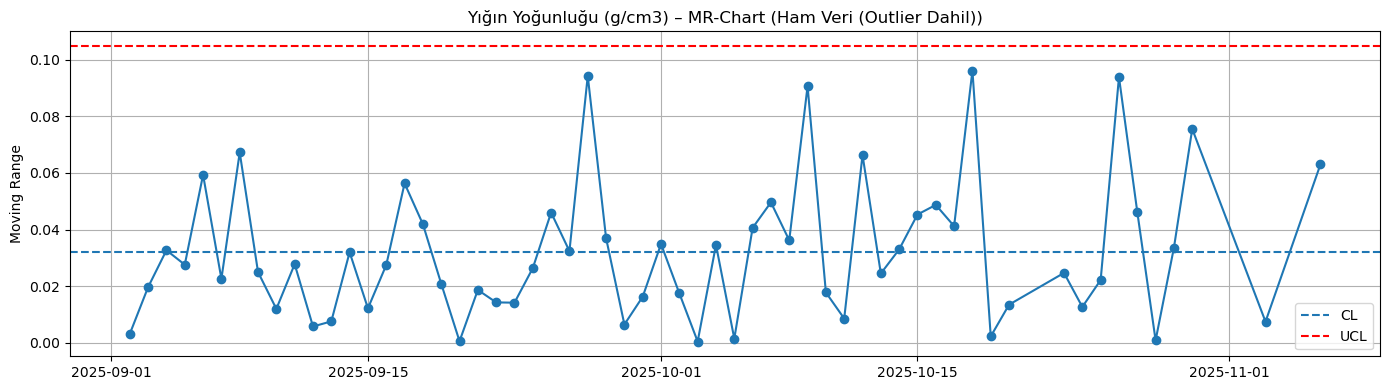

HAM → Mean: 1.1496 Sigma: 0.0284 Cp: 1.1729498228731563 Cpk: 1.1681407285993748


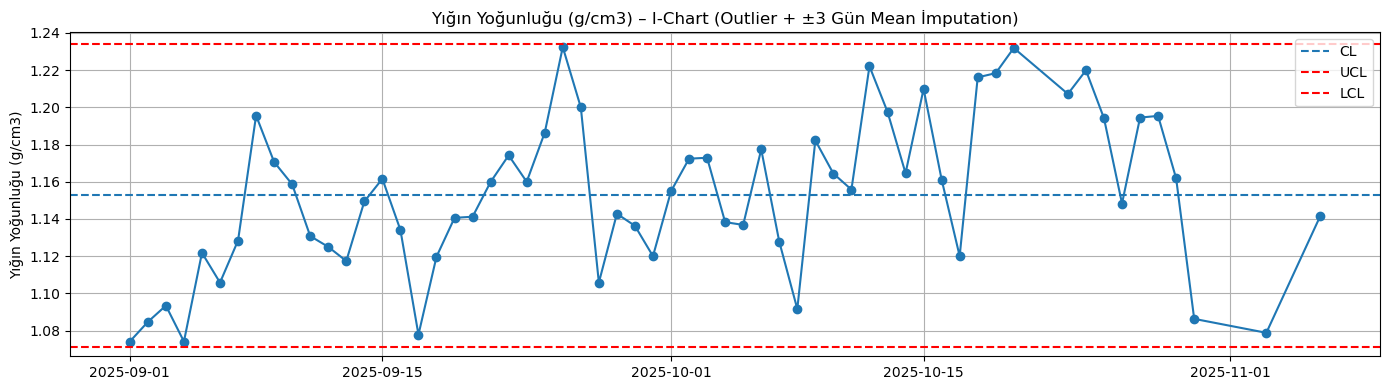

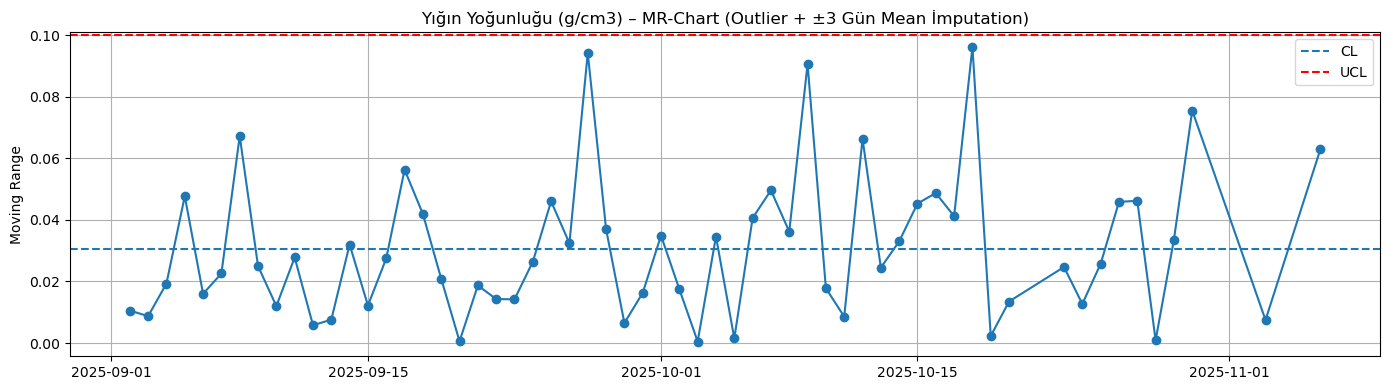

IMPUTE → Mean: 1.1528 Sigma: 0.0271 Cp: 1.2278597849194832 Cpk: 1.1937007257030239


In [6]:
for param, limits in PARAMETERS.items():
    print("\n" + "="*60)
    print("PARAMETRE:", param)
    print("="*60)

    # =====================
    # HAM VERİ
    # =====================
    stats_raw = draw_imr(df, param, "Ham Veri (Outlier Dahil)")
    Cp_raw, Cpk_raw = cp_cpk(
        stats_raw["mean"],
        stats_raw["sigma"],
        LSL=limits.get("LSL"),
        USL=limits.get("USL")
    )

    print("HAM → Mean:", round(stats_raw["mean"],4),
          "Sigma:", round(stats_raw["sigma"],4),
          "Cp:", Cp_raw,
          "Cpk:", Cpk_raw)

    # =====================
    # IMPUTATION SONRASI
    # =====================
    stats_imp = draw_imr(df_imputed, param, "Outlier + ±3 Gün Mean İmputation")
    Cp_imp, Cpk_imp = cp_cpk(
        stats_imp["mean"],
        stats_imp["sigma"],
        LSL=limits.get("LSL"),
        USL=limits.get("USL")
    )

    print("IMPUTE → Mean:", round(stats_imp["mean"],4),
          "Sigma:", round(stats_imp["sigma"],4),
          "Cp:", Cp_imp,
          "Cpk:", Cpk_imp)


yeterlilik

In [7]:
SPECIFICATIONS = {
    "NaHCO3 Ortalama(%)":      {"LSL": 99.3, "USL": None},
    "Na2CO3 Ortalama(%)":      {"LSL": None, "USL": 0.5},
    "Cl- Ortalama(mg/kg)":     {"LSL": None, "USL": 250},
    "SO42- Ortalama(mg/kg)":   {"LSL": None, "USL": 300},
    "SÇM Ortalama(mg/kg)":     {"LSL": None, "USL": 500},
    "S.Nem Ortalama(%)":       {"LSL": 0.0,  "USL": 0.05},
    "Yığın Yoğunluğu Ortalama(g/cm3)": {"LSL": 0.90, "USL": 1.25}
}
def cp_cpk_from_limits(mean, sigma, LSL=None, USL=None):
    if sigma is None or sigma == 0 or np.isnan(sigma):
        return np.nan, np.nan

    if LSL is not None and USL is not None:
        Cp = (USL - LSL) / (6 * sigma)
        Cpk = min(
            (USL - mean) / (3 * sigma),
            (mean - LSL) / (3 * sigma)
        )
    elif USL is not None:
        Cp = (USL - mean) / (3 * sigma)
        Cpk = Cp
    elif LSL is not None:
        Cp = (mean - LSL) / (3 * sigma)
        Cpk = Cp
    else:
        Cp, Cpk = np.nan, np.nan

    return Cp, Cpk


In [8]:
def imr_stats(df, col):
    x = df[col].dropna().values
    MR = np.abs(np.diff(x))
    d2 = 1.128

    mean = np.mean(x)
    sigma = np.mean(MR) / d2 if np.mean(MR) > 0 else np.nan

    return mean, sigma


In [9]:
results = []

for param, spec in PARAMETERS.items():
    mean, sigma = imr_stats(df_imputed, param)

    LSL = spec.get("LSL")
    USL = spec.get("USL")

    if sigma == 0 or np.isnan(sigma):
        Cp = Cpk = np.nan
    else:
        if LSL is not None and USL is not None:
            Cp = (USL - LSL) / (6 * sigma)
            Cpk = min(
                (USL - mean) / (3 * sigma),
                (mean - LSL) / (3 * sigma)
            )
        elif USL is not None:
            Cp = (USL - mean) / (3 * sigma)
            Cpk = Cp
        elif LSL is not None:
            Cp = (mean - LSL) / (3 * sigma)
            Cpk = Cp
        else:
            Cp = Cpk = np.nan

    if np.isnan(Cpk):
        status = "Hesaplanamadı"
    elif Cpk >= 1.33:
        status = "Yeterli"
    elif Cpk >= 1.00:
        status = "Şartlı"
    else:
        status = "Yetersiz"

    results.append({
        "Parametre": param,
        "Mean (CL)": round(mean, 5),
        "Sigma (I-MR)": round(sigma, 5),
        "LSL": LSL,
        "USL": USL,
        "Cp": None if np.isnan(Cp) else round(Cp, 3),
        "Cpk": None if np.isnan(Cpk) else round(Cpk, 3),
        "Durum": status
    })

results_df = pd.DataFrame(results)
display(results_df)


,Parametre,Mean (CL),Sigma (I-MR),LSL,USL,Cp,Cpk,Durum
0,NaHCO3 (%),99.74014,0.04404,99.60,99.90,1.135,1.061,Şartlı
1,Na2CO3 (%),0.11778,0.02834,0.08,0.15,0.412,0.379,Yetersiz
2,Cl- (mg/kg),123.13793,25.19362,NaN,200.00,1.017,1.017,Şartlı
3,SO42-(mg/kg),203.35911,53.08634,NaN,300.00,0.607,0.607,Yetersiz
4,SÇM (mg/kg),380.51140,55.37121,NaN,600.00,1.321,1.321,Şartlı
5,Nem (%),0.01406,0.00775,NaN,0.05,1.545,1.545,Yeterli
6,Yığın Yoğunluğu (g/cm3),1.15278,0.02715,1.05,1.25,1.228,1.194,Şartlı


/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/duyguxozel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

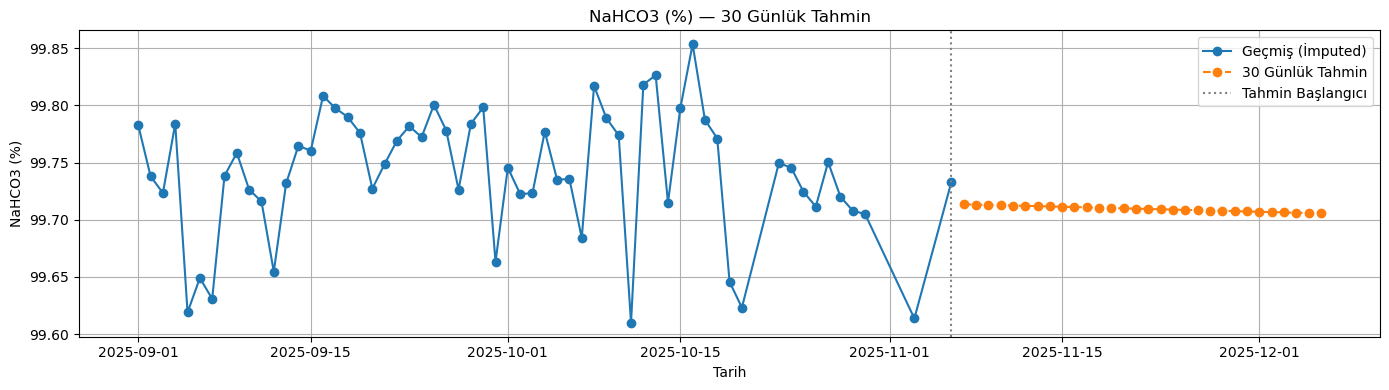

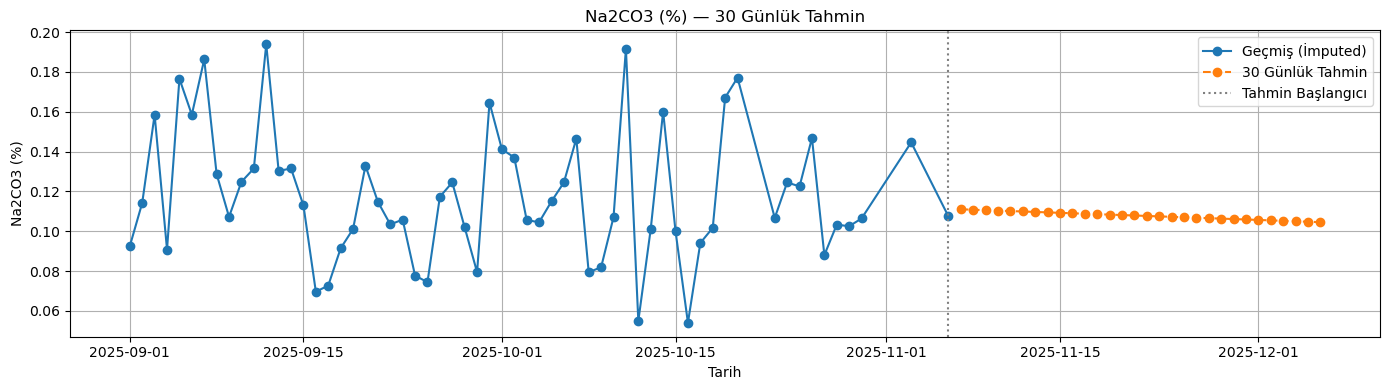

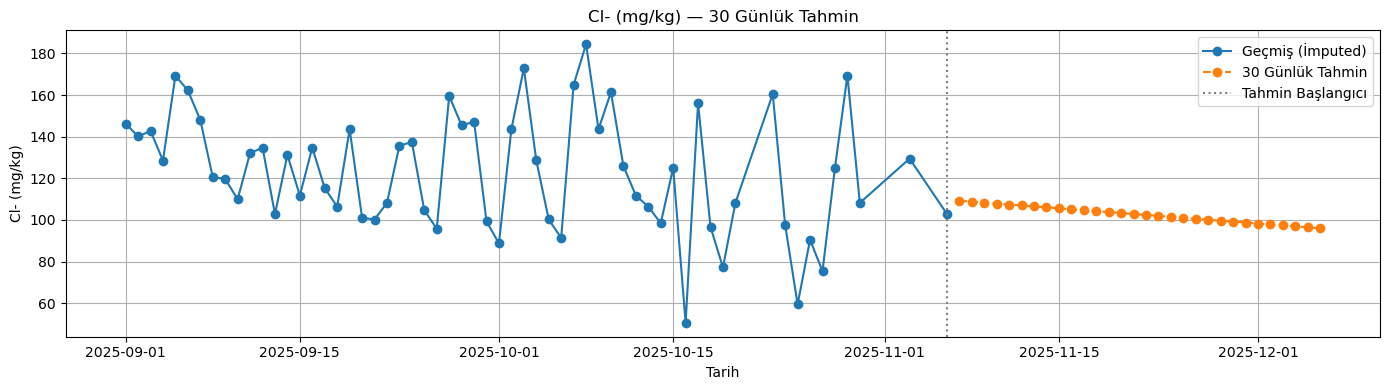

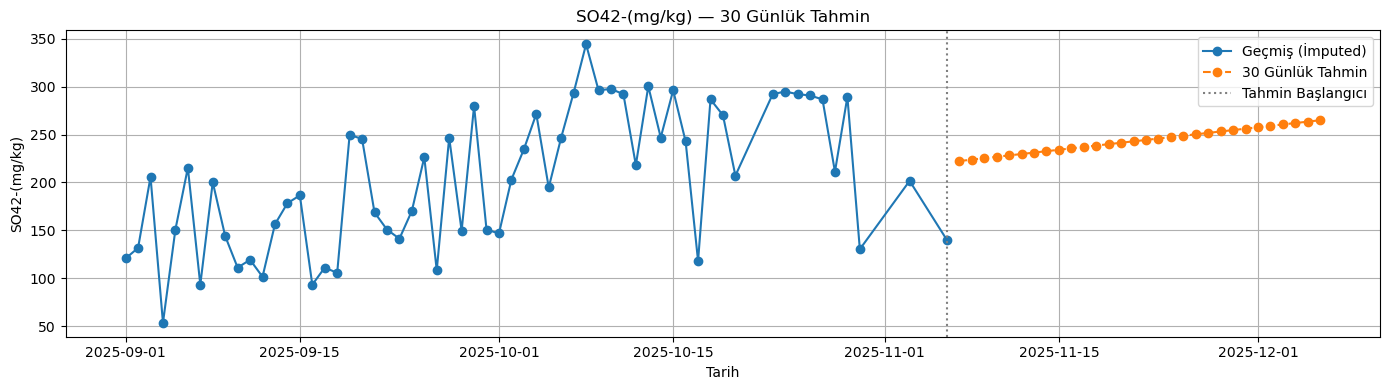

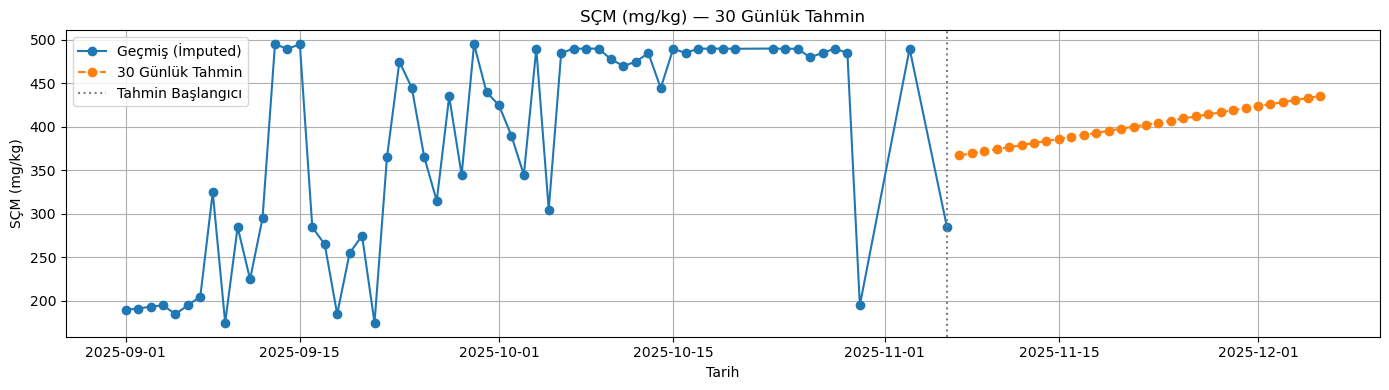

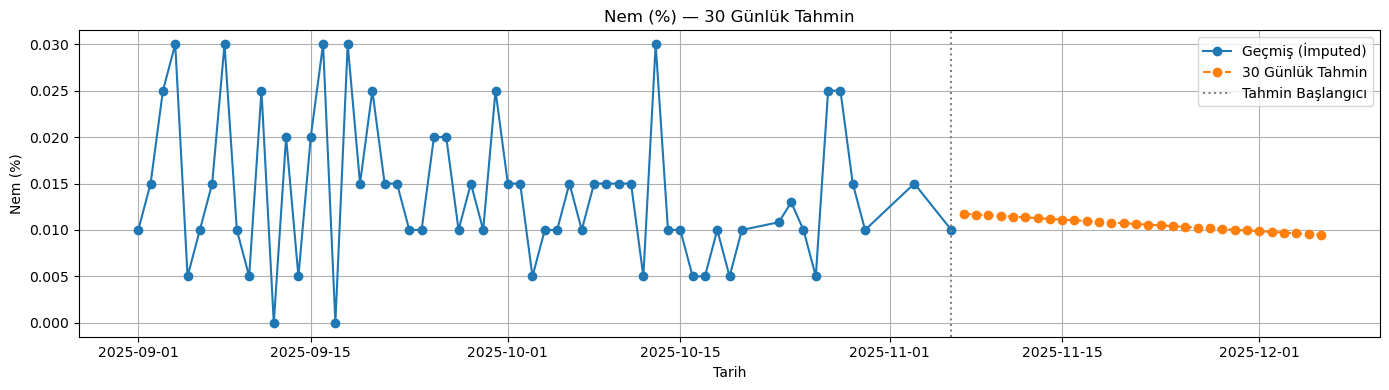

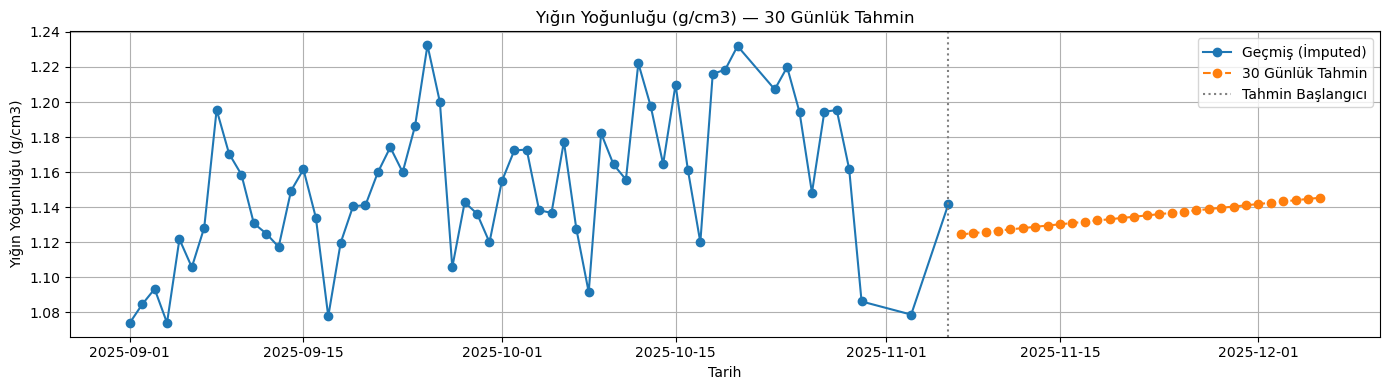


📈 30 Günlük Tahmin — İlk 10 Gün



,NaHCO3 (%),Na2CO3 (%),Cl- (mg/kg),SO42-(mg/kg),SÇM (mg/kg),Nem (%),Yığın Yoğunluğu (g/cm3)
2025-11-07,99.713532,0.111017,109.215949,222.332795,367.257314,0.011738,1.124509
2025-11-08,99.713257,0.110794,108.759491,223.801614,369.611703,0.011660,1.125232
2025-11-09,99.712982,0.110571,108.303032,225.270432,371.966092,0.011582,1.125955
2025-11-10,99.712707,0.110348,107.846574,226.739250,374.320481,0.011504,1.126678
2025-11-11,99.712433,0.110125,107.390116,228.208069,376.674870,0.011426,1.127401
2025-11-12,99.712158,0.109902,106.933657,229.676887,379.029259,0.011348,1.128123
2025-11-13,99.711883,0.109679,106.477199,231.145705,381.383648,0.011270,1.128846
2025-11-14,99.711609,0.109455,106.020740,232.614524,383.738037,0.011192,1.129569
2025-11-15,99.711334,0.109232,105.564282,234.083342,386.092427,0.011114,1.130292
2025-11-16,99.711059,0.109009,105.107823,235.552160,388.446816,0.011036,1.131015


In [10]:
# =====================================================
# FAZ 2 — 30 GÜNLÜK TAHMİN
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# -----------------------------------------------------
# 1️⃣ df_imputed hazır varsayılıyor
#     (Datetime + parametre kolonları var)
# -----------------------------------------------------

df_ts = df_imputed.copy()
df_ts = df_ts.sort_values("Datetime")
df_ts = df_ts.set_index("Datetime")

# -----------------------------------------------------
# 2️⃣ Tahmin edilecek parametreler
# -----------------------------------------------------
FORECAST_COLS = [
    "NaHCO3 (%)",
    "Na2CO3 (%)",
    "Cl- (mg/kg)",
    "SO42-(mg/kg)",
    "SÇM (mg/kg)",
    "Nem (%)",
    "Yığın Yoğunluğu (g/cm3)"
]

# -----------------------------------------------------
# 3️⃣ 30 günlük horizon
# -----------------------------------------------------
HORIZON = 30
last_date = df_ts.index.max()
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=HORIZON,
    freq="D"
)

forecast_df = pd.DataFrame(index=future_dates)

# -----------------------------------------------------
# 4️⃣ MODELLEME + TAHMİN
# -----------------------------------------------------
for col in FORECAST_COLS:
    series = df_ts[col].dropna()

    # Minimum veri kontrolü
    if len(series) < 10:
        print(f"⚠️ {col}: Yetersiz veri, atlandı")
        continue

    model = ExponentialSmoothing(
        series,
        trend="add",
        seasonal=None
    )

    fitted = model.fit(optimized=True)
    forecast = fitted.forecast(HORIZON)

    forecast_df[col] = forecast.values

# -----------------------------------------------------
# 5️⃣ GRAFİK — GEÇMİŞ + 30 GÜN TAHMİN
# -----------------------------------------------------
for col in FORECAST_COLS:
    if col not in forecast_df.columns:
        continue

    plt.figure(figsize=(14,4))

    plt.plot(
        df_ts.index,
        df_ts[col],
        label="Geçmiş (İmputed)",
        marker="o"
    )

    plt.plot(
        forecast_df.index,
        forecast_df[col],
        label="30 Günlük Tahmin",
        linestyle="--",
        marker="o"
    )

    plt.axvline(
        last_date,
        color="gray",
        linestyle=":",
        label="Tahmin Başlangıcı"
    )

    plt.title(f"{col} — 30 Günlük Tahmin")
    plt.ylabel(col)
    plt.xlabel("Tarih")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 6️⃣ Tahmin Tablosu (ilk 10 gün göster)
# -----------------------------------------------------
print("\n📈 30 Günlük Tahmin — İlk 10 Gün\n")
display(forecast_df.head(10))


In [11]:
import pandas as pd
import xgboost

print("pandas:", pd.__version__)
print("xgboost:", xgboost.__version__)


pandas: 2.0.3
xgboost: 1.5.0
